# Evaluation of RAG Using Ragas

## Videos to Watch:

[Art of Evaluation](https://www.youtube.com/watch?v=Anr1br0lLz8)

## Start of Hands-on:

In the following notebook we'll explore how to evaluate RAG pipelines using a powerful open-source tool called "Ragas". This will give us tools to evaluate component-wise metrics, as well as end-to-end metrics about the performance of our RAG pipelines.

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room Part #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating a simple RAG pipeline with [LangChain v0.1.0](https://blog.langchain.dev/langchain-v0-1-0/)
  

- 🤝 Breakout Room Part #2:
  1. Synthetic Dataset Generation for Evaluation using the [Ragas](https://github.com/explodinggradients/ragas)
  2. Evaluating our pipeline with Ragas
  3. Making Adjustments to our RAG Pipeline
  4. Evaluating our Adjusted pipeline against our baseline
  5. Testing OpenAI's Claim

The only way to get started is to get started - so let's grab our dependencies for the day!

## Motivation

A claim, made by OpenAI, is that their `text-embedding-3-small` is better (generally) than their `text-embedding-ada-002` model.

Here's some passages from their [blog](https://openai.com/blog/new-embedding-models-and-api-updates) about the `text-embedding-3` release:

> `text-embedding-3-small` is our new highly efficient embedding model and provides a significant upgrade over its predecessor, the `text-embedding-ada-002` model...

> **Stronger performance.** Comparing `text-embedding-ada-002` to `text-embedding-3-small`, the average score on a commonly used benchmark for multi-language retrieval ([MIRACL](https://github.com/project-miracl/miracl)) has increased from 31.4% to 44.0%, while the average score on a commonly used benchmark for English tasks ([MTEB](https://github.com/embeddings-benchmark/mteb)) has increased from 61.0% to 62.3%.

Well, with a library like Ragas - we can put that claim to the test!

If what they claim is true - we should see an increase on related metrics by using the new embedding model!

# 🤝 Breakout Room Part #1

## Task 1: Installing Required Libraries

A reminder that one of the [key features](https://blog.langchain.dev/langchain-v0-1-0/) of LangChain v0.1.0 is the compartmentalization of the various LangChain ecosystem packages!

So let's begin grabbing all of our LangChain related packages!

In [ ]:
%pip install -U -q langchain langchain-openai langchain_core langchain-community langchainhub openai

We'll also get the "star of the show" today, which is Ragas!

In [ ]:
%pip install -qU ragas

We'll be leveraging [QDrant](https://qdrant.tech/) again as our LangChain `VectorStore`.

We'll also install `pymupdf` and its dependencies which will allow us to load PDFs using the `PyMuPDFLoader` in the `langchain-community` package!

In [ ]:
%pip install -qU qdrant-client pymupdf pandas

## Task 2: Set Environment Variables

Let's set up our OpenAI API key so we can leverage their API later on.

In [10]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("Please provide your OpenAI Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

## Task 3: Creating a Simple RAG Pipeline with LangChain v0.1.0

Building on what we learned last week, we'll be leveraging LangChain v0.1.0 and LCEL to build a simple RAG pipeline that we can baseline with Ragas.

## Building our RAG pipeline

Let's review the basic steps of RAG again:

- Create an Index
- Use retrieval to obtain pieces of context from our Index that are similar to our query
- Use a LLM to generate responses based on the retrieved context

Let's get started by creating our index.

> NOTE: We're going to start leaning on the term "index" to refer to our `VectorStore`, `VectorDatabase`, etc. We can think of "index" as the catch-all term, whereas `VectorStore` and the like relate to the specific technologies used to create, store, and interact with the index.

### Creating an Index

You'll notice that the largest changes (outside of some import changes) are that our old favourite chains are back to being bundled in an easily usable abstraction.

We can still create custom chains using LCEL - but we can also be more confident that our pre-packaged chains are creating using LCEL under the hood.

#### Loading Data

Let's start by loading some data!

> NOTE: You'll notice that we're using a document loader from the community package of LangChain. This is part of the v0.1.0 changes that make the base (`langchain-core`) package remain lightweight while still providing access to some of the more powerful community integrations.

In [ ]:
!git clone https://github.com/AI-Maker-Space/DataRepository

In [ ]:
!git status

In [11]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader(
    "DataRepository/tswift_fued.pdf",
)

documents = loader.load()

In [5]:
documents[0].metadata

{'source': 'DataRepository/tswift_fued.pdf',
 'file_path': 'DataRepository/tswift_fued.pdf',
 'page': 0,
 'total_pages': 22,
 'format': 'PDF 1.4',
 'title': "A Timeline of Taylor Swift and Kim Kardashian's Feud",
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36',
 'producer': 'Skia/PDF m123',
 'creationDate': "D:20240423220523+00'00'",
 'modDate': "D:20240423220523+00'00'",
 'trapped': ''}

#### Transforming Data

Now that we've got our single document - let's split it into smaller pieces so we can more effectively leverage it with our retrieval chain!

We'll start with the classic: `RecursiveCharacterTextSplitter`.

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 50
)

documents = text_splitter.split_documents(documents)

Let's confirm we've split our document.

In [ ]:
len(documents)

#### Loading OpenAI Embeddings Model

We'll need a process by which we can convert our text into vectors that allow us to compare to our query vector.

Let's use OpenAI's `text-embedding-ada-002` for this task!

In [13]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)

#### Creating a QDrant VectorStore

Now that we have documents - we'll need a place to store them alongside their embeddings.

In [14]:
from langchain_community.vectorstores import Qdrant

qdrant_vector_store = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="Taylor Swift - Fued - ADA",
)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

####❓ Question #1:

List out a few of the techniques that Qdrant uses that make it performant.

> NOTE: Check the [documentation](https://qdrant.tech/documentation/overview/) for more information about FAISS!

- Hierarchical Navigable Small World -> used to implement Approximate Nearest Neighbors (example K Nearest Neighbor -> finding clostest points to a given point) – and Product Quantization (vector compression || centroid approximation) -> ultimately there's a tradeoff between accuraccy and (query) speed
- The most commonly used distance metrics are Euclidean Distance, Cosine Similarity, and Dot Product, and these three are fully supported Qdrant.

#### Creating a Retriever

To complete our index, all that's left to do is expose our vectorstore as a retriever - which we can do the same way we would in previous version of LangChain!

In [ ]:
retriever = qdrant_vector_store.as_retriever()

#### Testing our Retriever

Now that we've gone through the trouble of creating our retriever - let's see it in action!

In [ ]:
retrieved_documents = retriever.invoke("Who is Taylor Swift?")

In [ ]:
for doc in retrieved_documents:
  print(doc)

### Creating a RAG Chain

Now that we have the "R" in RAG taken care of - let's look at creating the "AG"!

#### Creating a Prompt Template

There are a few different ways we could create our prompt template - we could create a custom template, as seen in the code below, or we could simply pull a prompt from the prompt hub! Let's look at an example of that!

In [ ]:
from langchain import hub

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

In [ ]:
print(retrieval_qa_prompt.messages[0].prompt.template)

As you can see - the prompt template is simple (and has a small error) - so we'll create our own to be a bit more specific!

In [ ]:
from langchain.prompts import ChatPromptTemplate

template = """Answer the question based only on the following context. If you cannot answer the question with the context, please respond with 'I don't know':

Context:
{context}

Question:
{question}
"""

prompt = ChatPromptTemplate.from_template(template)

#### Setting Up our Basic QA Chain

Now we can instantiate our basic RAG chain!

We'll use LCEL directly just to see an example of it - but you could just as easily use an abstraction here to achieve the same goal!

We'll also ensure to pass-through our context - which is critical for RAGAS.

In [ ]:
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

primary_qa_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}
)

####🏗️ Activity #1:

Describe the pipeline shown above in simple terms. You can include a diagram if desired.

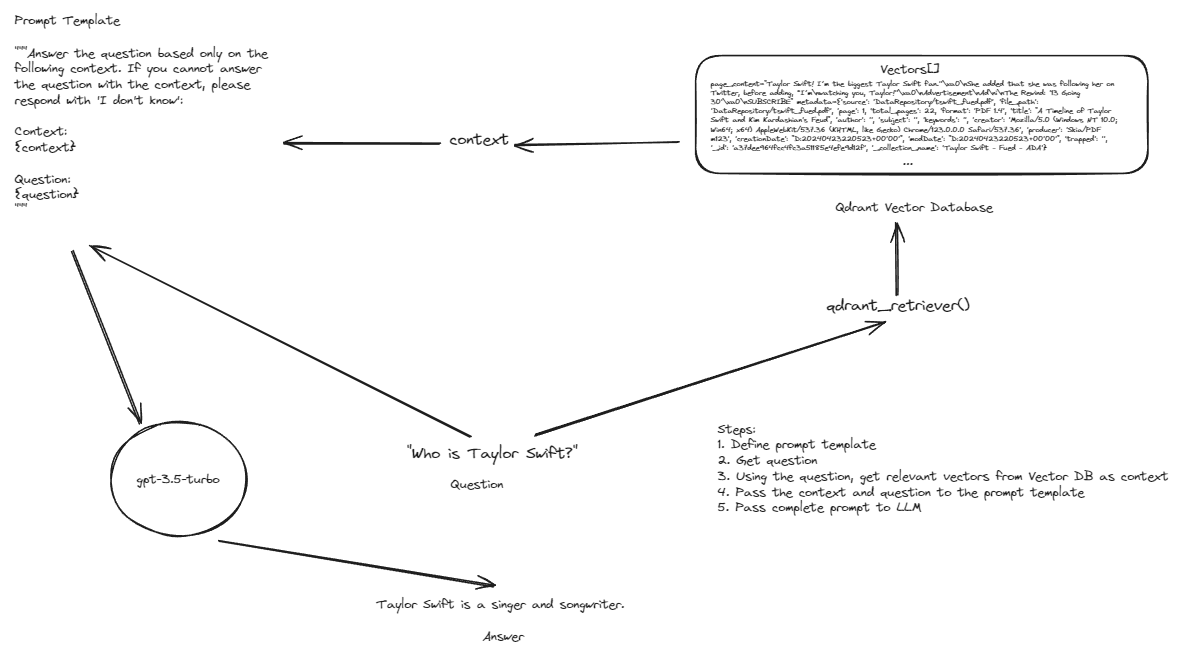

Let's test it out!

In [ ]:
question = "Who is Taylor Swift?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)

In [ ]:
question = "Why are they fueding?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)
print(result["context"])

We can already see that there are some improvements we could make here.

For now, let's switch gears to RAGAS to see how we can leverage that tool to provide us insight into how our pipeline is performing!

# 🤝 Breakout Room Part #2

## Task 1: Synthetic Dataset Generation for Evaluation using Ragas

Ragas is a powerful library that lets us evaluate our RAG pipeline by collecting input/output/context triplets and obtaining metrics relating to a number of different aspects of our RAG pipeline.

We'll be evaluating on every core metric today, but in order to do that - we'll need to create a test set. Luckily for us, Ragas can do that directly!

### Synthetic Test Set Generation

We can leverage Ragas' [`Synthetic Test Data generation`](https://docs.ragas.io/en/stable/concepts/testset_generation.html) functionality to generate our own synthetic QC pairs - as well as a synthetic ground truth - quite easily!

> NOTE: This process will use `gpt-3.5-turbo-16k` as the base generator and `gpt-4` as the critic - if you're attempting to create a lot of samples please be aware of cost, as well as rate limits.

In [ ]:
loader = PyMuPDFLoader(
    "DataRepository/tswift_fued.pdf",
)

eval_documents = loader.load()

text_splitter_eval = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap = 50
)

eval_documents = text_splitter_eval.split_documents(eval_documents)

####❓ Question #2:

Why is it important to split our documents using different parameters when creating our synthetic data?
- Larger chunk sizes preserve better context.

In [ ]:
len(eval_documents)

> NOTE: This cell will take ~5-6min. to generate. If you run into any rate-limit issues - please use GPT-3.5-Turbo as your `critic_llm`. If you see any fields marked `nan` - this is product of rate-limiting issues, and you can safely ignore them for now.

In [9]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
critic_llm = ChatOpenAI(model="gpt-3.5-turbo") 
# critic_llm = ChatOpenAI(model="gpt-4-turbo")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

testset = generator.generate_with_langchain_docs(eval_documents, 20, distributions, is_async = False)
testset.to_pandas()

NameError: name 'eval_documents' is not defined

####❓ Question #3:

`{simple: 0.5, reasoning: 0.25, multi_context: 0.25}`

What exactly does this mapping refer to?

> NOTE: Check out the Ragas documentation on this generation process [here](https://docs.ragas.io/en/stable/concepts/testset_generation.html).

Let's look at the output and see what we can learn about it!

In [ ]:
testset.test_data[0]

### Generating Responses with RAG Pipeline

Now that we have some QC pairs, and some ground truths, let's evaluate our RAG pipeline using Ragas.

The process is, again, quite straightforward - thanks to Ragas and LangChain!

Let's start by extracting our questions and ground truths from our create testset.

We can start by converting our test dataset into a Pandas DataFrame.

In [ ]:
test_df = testset.to_pandas()

In [ ]:
test_df

In [ ]:
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

Now we'll generate responses using our RAG pipeline using the questions we've generated - we'll also need to collect our retrieved contexts for each question.

We'll do this in a simple loop to see exactly what's happening!

In [ ]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_augmented_qa_chain.invoke({"question" : question})
  answers.append(response["response"].content)
  contexts.append([context.page_content for context in response["context"]])

Now we can wrap our information in a Hugging Face dataset for use in the Ragas library.

In [ ]:
from datasets import Dataset

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's take a peek and see what that looks like!

In [ ]:
response_dataset[0]

## Task 2: Evaluating our Pipeline with Ragas

Now that we have our response dataset - we can finally get into the "meat" of Ragas - evaluation!

First, we'll import the desired metrics, then we can use them to evaluate our created dataset!

Check out the specific metrics we'll be using in the Ragas documentation:

- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
- [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
- [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)

See the accompanied presentation for more in-depth explanations about each of the metrics!

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

All that's left to do is call "evaluate" and away we go!

In [ ]:
results = evaluate(response_dataset, metrics)

In [ ]:
results

In [ ]:
results_df = results.to_pandas()
results_df

## Task 3: Making Adjustments to our RAG Pipeline

Now that we have established a baseline - we can see how any changes impact our pipeline's performance!

Let's modify our retriever and see how that impacts our Ragas metrics!

> NOTE: MultiQueryRetriever is expanded on [here](https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever) but for now, the implementation is not important to our lesson!

In [ ]:
from langchain.retrievers import MultiQueryRetriever

advanced_retriever = MultiQueryRetriever.from_llm(retriever=retriever, llm=primary_qa_llm)

We'll also re-create our RAG pipeline using the abstractions that come packaged with LangChain v0.1.0!

First, let's create a chain to "stuff" our documents into our context!

In [ ]:
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)

Next, we'll create the retrieval chain!

In [ ]:
from langchain.chains import create_retrieval_chain

retrieval_chain = create_retrieval_chain(advanced_retriever, document_chain)

In [ ]:
response = retrieval_chain.invoke({"input": "Who is Taylor Swift fueding with?"})

In [ ]:
print(response["answer"])

In [ ]:
response = retrieval_chain.invoke({"input": "Why are they fueding?"})

In [ ]:
print(response["answer"])

Well, just from those responses this chain *feels* better - but lets see how it performs on our eval!

Let's do the same process we did before to collect our pipeline's contexts and answers.

In [ ]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

Now we can convert this into a dataset, just like we did before.

In [ ]:
response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's evaluate on the same metrics we did for the first pipeline and see how it does!

In [ ]:
advanced_retrieval_results = evaluate(response_dataset_advanced_retrieval, metrics)

In [ ]:
advanced_retrieval_results_df = advanced_retrieval_results.to_pandas()
advanced_retrieval_results_df

## Task 4: Evaluating our Adjusted Pipeline Against Our Baseline

Now we can compare our results and see what directional changes occured!

Let's refresh with our initial metrics.

In [ ]:
results

And see how our advanced retrieval modified our chain!

In [ ]:
advanced_retrieval_results

In [ ]:
import pandas as pd

df_original = pd.DataFrame(list(results.items()), columns=['Metric', 'Baseline'])
df_comparison = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'MultiQueryRetriever with Document Stuffing'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')

df_merged['Delta'] = df_merged['MultiQueryRetriever with Document Stuffing'] - df_merged['Baseline']

df_merged

## Task 5: Testing OpenAI's Claim

Now that we've seen how our retriever can impact the performance of our RAG pipeline - let's see how changing our embedding model impacts performance.

####🏗️ Activity #2:

Please provide markdown, or code comments, to explain which each of the following steps are doing!

In [ ]:
new_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [ ]:
vector_store = qdrant = Qdrant.from_documents(
    documents,
    new_embeddings,
    location=":memory:",
    collection_name="Taylor Swift - Fued - MQR",
)

In [ ]:
new_retriever = vector_store.as_retriever()

In [ ]:
new_advanced_retriever = MultiQueryRetriever.from_llm(retriever=new_retriever, llm=primary_qa_llm)

In [ ]:
new_retrieval_chain = create_retrieval_chain(new_advanced_retriever, document_chain)

In [ ]:
answers = []
contexts = []

for question in test_questions:
  response = new_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

In [ ]:
new_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

In [ ]:
new_advanced_retrieval_results = evaluate(new_response_dataset_advanced_retrieval, metrics)

In [ ]:
new_advanced_retrieval_results

In [ ]:
df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'Baseline'])
df_original = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'ADA'])
df_comparison = pd.DataFrame(list(new_advanced_retrieval_results.items()), columns=['Metric', 'Text Embedding 3'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')
df_merged = pd.merge(df_baseline, df_merged, on="Metric")

df_merged['Delta - TE3 -> ADA'] = df_merged['Text Embedding 3'] - df_merged['ADA']
df_merged['Delta - TE3 -> Baseline'] = df_merged['Text Embedding 3'] - df_merged['Baseline']

df_merged

####❓ Question #4:

Do you think, in your opinion, `text-embedding-3-small` is significantly better than `ada`?

## BONUS ACTIVITY: Showcase Multi-Context Perfomance Changes

Now that we've looked at a number of different examples - showcase the difference on the multi-context *specific* questions that were synthetically generated.

> NOTE: You have all the data you'll need already in the notebook if you made it to this step!

In [ ]:
### YOUR CODE HERE